In [1]:
# from google.colab import drive
# drive.mount("/content/MyDrive")

##Librairies

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import hashlib
from tqdm.notebook import tqdm
import os
warnings.filterwarnings('ignore')
import psutil
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from transformers import RobertaTokenizer,AutoTokenizer,AutoConfig,AutoModel
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
import torch.nn.functional as F
from transformers import get_linear_schedule_with_warmup
from collections import defaultdict
from sklearn.model_selection import train_test_split


In [3]:
def memory_check():
  return round(psutil.virtual_memory().used/1024**3,3)

In [4]:
# os.chdir('/content/MyDrive/MyDrive/Colab Notebooks/securityBERT')

##PPFLE Algorithm

In [5]:
def H(x):
  hasher = hashlib.sha1() #returns a hashed value of 256 bits
  hasher.update(x.encode('utf-8'))
  hashed = hasher.hexdigest()

  return hashed


In [6]:
def s(i,j):
  return str(i)+"$"+str(j) #To concatenate the column name with the cell value

In [7]:
def PPFLE(M):
  columns = list(data.columns[:-2])
  # print(columns)
  # return 0
  DL = []
  for i,v in tqdm(M.iterrows(),desc="Processing...",total=len(M)):
    L = []
    for j in columns:
      L.append(H(s(j,v.get(j))))
    DL.append(" ".join(L))
  return DL


In [8]:
# features_to_remove = ['frame.time','ip.src_host', 'ip.dst_host','arp.dst.proto_ipv4','tcp.payload']
# print(data.shape)
# data = data.drop(columns=features_to_remove,axis=0)
# data.shape

In [9]:
data = pd.read_csv(".\data\Edge-IIoTset dataset\Selected dataset for ML and DL\ML-EdgeIIoT-dataset.csv")
data.head(5)

,frame.time,ip.src_host,ip.dst_host,arp.dst.proto_ipv4,arp.opcode,arp.hw.size,arp.src.proto_ipv4,icmp.checksum,icmp.seq_le,icmp.transmit_timestamp,...,mqtt.proto_len,mqtt.protoname,mqtt.topic,mqtt.topic_len,mqtt.ver,mbtcp.len,mbtcp.trans_id,mbtcp.unit_id,Attack_label,Attack_type
0,6.0,192.168.0.152,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,MITM
1,6.0,192.168.0.101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,MITM
2,6.0,192.168.0.152,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,MITM
3,6.0,192.168.0.101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,MITM
4,6.0,192.168.0.152,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,MITM


In [10]:
data['Attack_type'].value_counts()

Attack_type
Normal                   24301
DDoS_UDP                 14498
DDoS_ICMP                14090
Ransomware               10925
DDoS_HTTP                10561
SQL_injection            10311
Uploading                10269
DDoS_TCP                 10247
Backdoor                 10195
Vulnerability_scanner    10076
Port_Scanning            10071
XSS                      10052
Password                  9989
MITM                      1214
Fingerprinting            1001
Name: count, dtype: int64

In [11]:
colonnes_objet = data.select_dtypes(include=['object']).columns
colonnes_objet = list(colonnes_objet[:-2])

In [12]:
for column in tqdm(colonnes_objet):
  data[column] = data[column].astype(str)


  0%|          | 0/18 [00:00<?, ?it/s]

In [13]:
data.sample(5)

,frame.time,ip.src_host,ip.dst_host,arp.dst.proto_ipv4,arp.opcode,arp.hw.size,arp.src.proto_ipv4,icmp.checksum,icmp.seq_le,icmp.transmit_timestamp,...,mqtt.proto_len,mqtt.protoname,mqtt.topic,mqtt.topic_len,mqtt.ver,mbtcp.len,mbtcp.trans_id,mbtcp.unit_id,Attack_label,Attack_type
51282,2021 19:08:33.282252000,121.56.225.103,192.168.0.128,0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,DDoS_TCP
138615,100.0.190.101,192.168.0.128,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,DDoS_UDP
153200,2021 23:22:36.717087000,209.145.11.213,192.168.0.128,0,0.0,0.0,0,33371.0,40238.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,DDoS_ICMP
11187,2021 00:01:17.148344000,192.168.0.128,192.168.0.170,0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,Ransomware
98730,2021 18:36:24.474189000,192.168.0.170,192.168.0.128,0,0.0,0.0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,XSS


In [14]:
temp = PPFLE(data)

Processing...:   0%|          | 0/157800 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
data['encoded_PPFLE'] = temp
del temp

In [ ]:
data = data[['encoded_PPFLE','Attack_type','Attack_label']]

In [ ]:
data.to_pickle('./saved_data/encoded_data.pck')

##Load saved data

In [ ]:
data = pd.read_pickle('./saved_data/encoded_data.pck')

In [ ]:
le = LabelEncoder()
data['target'] = le.fit_transform(data['Attack_type'])

In [ ]:
data.sample(3)

,encoded_PPFLE,Attack_type,Attack_label,target
3075,13cdb7ff3cef6a12ab3a87226b04637ee9c2157b 6df8d...,Ransomware,1,10
25345,f520c2f5c57a93d27d25d1a44fbd30fd7eb909e8 6df8d...,SQL_injection,1,11
61397,f9c754dceaf0b83f5f79a34eb65581d276dc23c1 0bc16...,Password,1,8


In [ ]:
data['encoded_PPFLE'][0]

'689e1d00f39f485bd2da5098239199df85c39b4d 2ab932d3aadb7887eda7302e0b33df13dc5ca645 f2c86566785eaad29f5c4b244d058b0cb7deb97e 5ea155b76662c1b381a0526e87d733a2ae68bfce b3625a98258ceacc69889389baca3b048a4923e4 8d419a4b06c3bd95d00fe2ee5cf1146851cf9893 c71f6d1e2daf2f598381088226df35ae68552f0b b7036347f54fa5aef0dd3f66b4e44c56bbf54cf4 f97d947902327761a4b1472d76b71bf4406e4e18 79ae7b95cace51fb0079d9c5ef1641f4639ce3ed ea25a11eb9c83b7d70252710098ded6bc81eb62b ceae604760aaa4fd8b60791ae1839b754c2dd9f1 23197a0ba8a217f2bc8711ec3c4be39dc19236d7 e2df55df19acd4423bafccbb0b8a385ec5e914eb f086df09fafdda401160bc766631e3d5785a6257 5329d5d159837e103352035068b3e14ce570d7eb 3eb6e4b9dd1c085a3ad0b18484d48482c935a4f7 943315f7b6cb0fc45604f5cf2ac307894e59b990 89b029338e8dd73f49369cd01c0052663c8c949e f91e2919e7494d796d1148066124d4b4939c86fa a5ce077c8900f85e073032ae975d95491645ddce effcfb2aa80217f507218ea88726c9325a0d68b9 bf12d74b6502b4fc1e29df164d3bf6f6ce51ffe3 7d69c36dbc4a37fc6643a32e914ea4e7ee0f0fc2 128f4c3fdc8539e

In [ ]:
sorted(data['target'].unique())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

In [ ]:
# data.to_pickle('./encoded_data.pickle')

In [ ]:
memory_check()

23.502

In [ ]:
with open("encoded_data.txt","w") as f:
  for value in tqdm(data['encoded_PPFLE']):
    f.write(str(value)+'\n')


  0%|          | 0/157800 [00:00<?, ?it/s]

##Data splitting

In [ ]:
train_set = data.sample(frac=0.7,random_state=42).reset_index(drop=True)

remaining = data.drop(train_set.index).reset_index(drop=True)

test_set = remaining.sample(frac=0.5,random_state=42).reset_index(drop=True)

val_set = remaining.drop(test_set.index).reset_index(drop=True)

print(train_set.shape,val_set.shape,test_set.shape)

(110460, 4) (23670, 4) (23670, 4)


In [ ]:
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

In [ ]:
train_set, test_set = train_test_split(data, test_size=test_ratio,stratify=data.iloc[:,-1], random_state=42)
train_set, val_set = train_test_split(train_set, test_size=val_ratio/(val_ratio+train_ratio),stratify=train_set.iloc[:,-1], random_state=42)


In [ ]:
train_set.shape,val_set.shape,test_set.shape

((110460, 4), (23670, 4), (23670, 4))

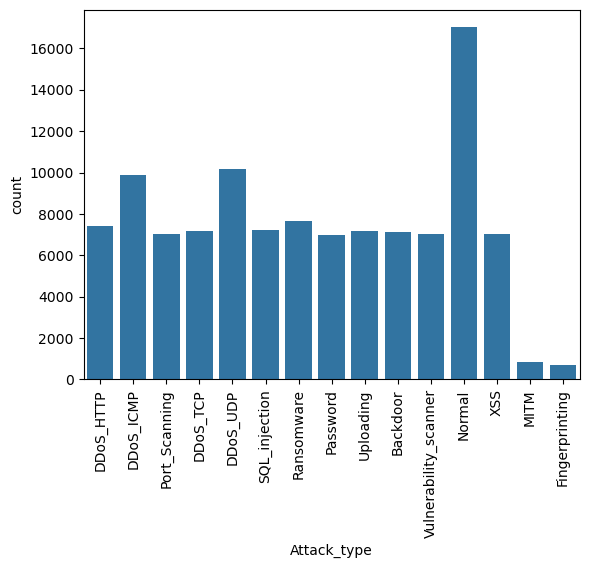

In [ ]:
sns.countplot(train_set,x='Attack_type')
plt.xticks(rotation=90)
plt.show()

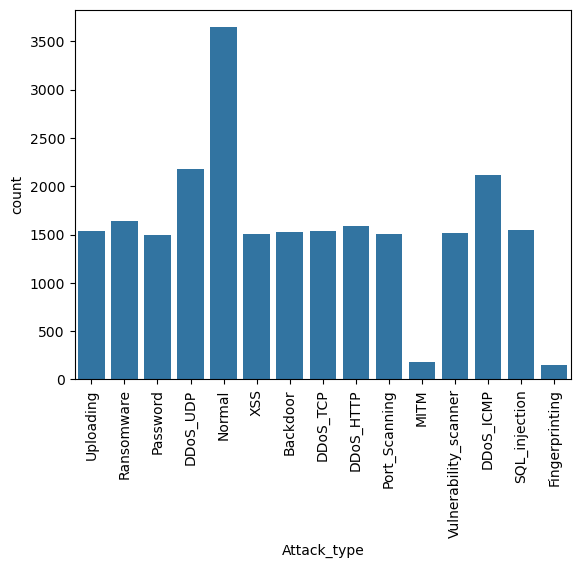

In [ ]:
sns.countplot(val_set,x='Attack_type');
plt.xticks(rotation=90)
plt.show()

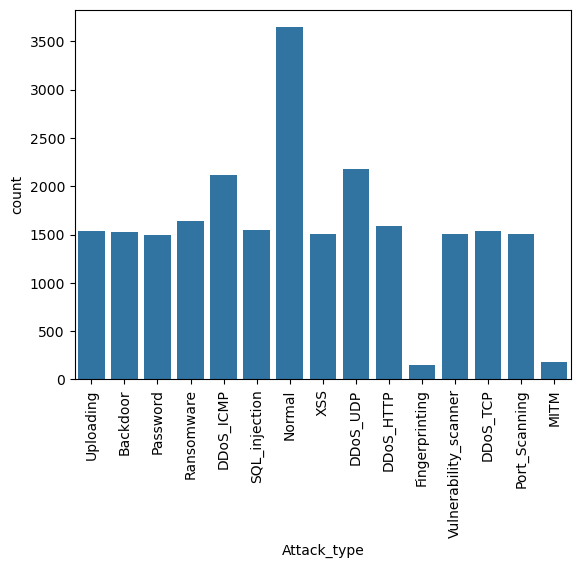

In [ ]:
sns.countplot(test_set,x='Attack_type')
plt.xticks(rotation=90)
plt.show()

In [ ]:
TARGET_LIST = ['Backdoor', 'DDoS_HTTP', 'DDoS_ICMP', 'DDoS_TCP', 'DDoS_UDP',
                'Fingerprinting', 'MITM', 'Normal', 'Password', 'Port_Scanning',
                'Ransomware', 'SQL_injection', 'Uploading', 'Vulnerability_scanner',
                'XSS']

In [ ]:
data[data['Attack_type']=='Uploading'].head(5)

,encoded_PPFLE,Attack_type,Attack_label,target
13140,05293357ba325a590027981a9b59eb748a968bb8 0bc16...,Uploading,1,12
13141,da0992898db14d190c3b6f7c2c6c658259a2b3a4 0bc16...,Uploading,1,12
13142,4d5b89f0a6797f41a5d0ee5b7b1cfe1327a291f4 0bc16...,Uploading,1,12
13143,732fcefab7fb269fd8ae7bd4d3b3e28ec3310e1f 6df8d...,Uploading,1,12
13144,9a7d459b7d8a0e5c070cb85c3b1bd0824a7b010f 0bc16...,Uploading,1,12


##BBPE algorithm

In [ ]:
# "cuda" if torch.cuda.is_available() else 
device = torch.device('cpu')
device

device(type='cpu')

In [ ]:
from tokenizers import ByteLevelBPETokenizer

In [ ]:
tokenizer = ByteLevelBPETokenizer()

In [ ]:
%%time
tokenizer.train('./encoded_data.txt',vocab_size=30522,min_frequency=2,
                special_tokens=[
                    '<s>','<pad>','</s>','<unk>','<mask>'

                ])

CPU times: total: 4min 33s
Wall time: 16.7 s


In [ ]:
# os.mkdir('tokenizer')

In [ ]:
tokenizer.save_model("./tokenizer/")

['./tokenizer/vocab.json', './tokenizer/merges.txt']

##Model section

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained('./tokenizer')

In [ ]:
len(tokenizer.get_vocab())

30522

##Dataset and DataLoader

In [ ]:
class CustomDataset(Dataset):
  def __init__(self,df,tokenizer,max_len):
    self.df = df
    self.tokenizer = tokenizer
    self.max_len=max_len
    self.sequence = self.df['encoded_PPFLE'].tolist()
    self.targets = self.df['target'].tolist()

  def __len__(self):
    return len(self.df)

  def __getitem__(self,idx):
    sequence = str(self.sequence[idx])
    target = self.targets[idx]
    encoding = self.tokenizer.encode_plus(
        sequence,
        add_special_tokens=True,
        max_length=self.max_len,
        padding='max_length',
        return_token_type_ids=False,
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    return {
        'input_ids':encoding['input_ids'].flatten(),
        'attention_mask':encoding['attention_mask'].flatten(),
        'targets':torch.tensor(target,dtype=torch.long)
    }


In [ ]:
MAX_LEN=512
BATCH_SIZE=32

In [ ]:
train_dataset = CustomDataset(train_set,tokenizer=tokenizer,max_len=MAX_LEN)
val_dataset = CustomDataset(val_set,tokenizer=tokenizer,max_len=MAX_LEN)
test_dataset = CustomDataset(test_set,tokenizer=tokenizer,max_len=MAX_LEN)

In [ ]:
train_loader = DataLoader(
    train_dataset,
    shuffle=True,
    batch_size=BATCH_SIZE,
    num_workers=0

)

val_loader = DataLoader(
    val_dataset,
    shuffle=False,
    batch_size=BATCH_SIZE,
    num_workers=0

)

test_loader = DataLoader(
    test_dataset,
    shuffle=False,
    batch_size=BATCH_SIZE,
    num_workers=0

)

#Fine tuning BERT

In [ ]:
# Switched from "bert-base-uncased" to "bert-mini-uncased"
config = AutoConfig.from_pretrained("bert-base-uncased")
config

BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.52.4",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [ ]:
config.hidden_size = 256
config.num_hidden_layers = 4
config.num_attention_heads = 16
config.intermediate_size = 512
config.vocab_size=7000

In [ ]:
finetunedBERT = AutoModel.from_config(config)

In [ ]:
finetunedBERT

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(7000, 256, padding_idx=0)
    (position_embeddings): Embedding(512, 256)
    (token_type_embeddings): Embedding(2, 256)
    (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-3): 4 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=256, out_features=256, bias=True)
            (key): Linear(in_features=256, out_features=256, bias=True)
            (value): Linear(in_features=256, out_features=256, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=256, out_features=256, bias=True)
            (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
 

###Model paramerters

In [ ]:
sum(p.numel() for p in finetunedBERT.parameters())

4098304

##Model definition

In [ ]:
class SecurityBERT(nn.Module):
  def __init__(self,finetunedBERT,n_classes):
    super(SecurityBERT,self).__init__()
    self.bert = finetunedBERT
    self.dropout = nn.Dropout(p=0.1)
    self.out = nn.Linear(self.bert.config.hidden_size,n_classes)

  def forward(self,input_ids,attention_mask):
    pooled_output = self.bert(
        input_ids=input_ids,
        attention_mask=attention_mask
    ).pooler_output

    output = self.dropout(pooled_output)

    return self.out(output)


In [ ]:
test_data = next(iter(train_loader))

print(test_data['input_ids'].shape)

torch.Size([32, 512])


In [ ]:
input_ids = test_data['input_ids'].to(device)
attention_mask = test_data['attention_mask'].to(device)
securityBert = SecurityBERT(finetunedBERT=finetunedBERT,n_classes=len(TARGET_LIST)).to(device)

res = nn.functional.softmax(securityBert(input_ids,attention_mask),dim=1)


IndexError: index out of range in self

###Subsection of training


In [ ]:
def load_chkpt(model,version):
  return model.load_state_dict(torch.load(f"./saved_model/securityBert{version}.0.pt",map_location=torch.device('cpu')))

##Training and Evaluation

In [ ]:
def train_model(model,data_loader,loss_fn,optimizer,device,scheduler,n_examples):
  model = model.train()

  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d['input_ids'].to(device)
    attention_mask = d['attention_mask'].to(device)
    targets = d['targets'].to(device)

    outputs = model(input_ids,attention_mask)
    _,preds = torch.max(outputs,dim=1)
    loss = loss_fn(outputs,targets)

    correct_predictions+=torch.sum(preds==targets).cpu()

    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm(model.parameters(),max_norm=1.0)

    optimizer.step()
    scheduler.step()

    optimizer.zero_grad()

  return correct_predictions/n_examples,np.mean(losses)




In [ ]:
def evaluation_model(model,data_loader,loss_fn,device,n_examples):
  model = model.train()

  losses = []
  correct_predictions = 0

  for d in data_loader:
    input_ids = d['input_ids'].to(device)
    attention_mask = d['attention_mask'].to(device)
    targets = d['targets'].to(device)

    outputs = model(input_ids,attention_mask)
    _,preds = torch.max(outputs,dim=1)

    loss = loss_fn(outputs,targets)

    correct_predictions+=torch.sum(preds==targets).cpu()

    losses.append(loss.item())

  return correct_predictions/n_examples,np.mean(losses)

In [ ]:
EPOCHS=3
optimizer = torch.optim.AdamW(securityBert.parameters(),lr=1e-5)
total_steps = len(train_loader)*EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps= 0,
    num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
%%time
history = defaultdict(list)
best_accuracy=0
for epoch in tqdm(range(EPOCHS)):
  print(f"Epoch {epoch+1}/{EPOCHS}")
  train_acc,train_loss = train_model(securityBert,train_loader,loss_fn,optimizer,device,scheduler,len(train_set))
  val_acc,val_loss = evaluation_model(securityBert,val_loader,loss_fn,device,len(val_set))
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  print(f"Train Loss {train_loss} | Validation Loss {val_loss} |Training Accuracy {train_acc} |Validation Accuracy {val_acc}")

  if val_acc>best_accuracy:
    torch.save(securityBert.state_dict(),f"./saved_model/securityBert{epoch+1}.0.pt")
    best_accuracy = val_acc


In [ ]:
epochs = range(1, EPOCHS+1)
train_losses = history['train_loss']
val_losses = history['val_loss']

# Création du graphique
plt.figure(figsize=(10, 6))

# Tracé des courbes de training et de validation losses
sns.lineplot(x=epochs, y=train_losses, label='Training Loss',marker="o")
sns.lineplot(x=epochs, y=val_losses, label='Validation Loss',marker="o")

# Ajout de titres et de légendes
plt.title('Training et Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('./training-validation-losses.png',dpi=780)
# Affichage du graphique
plt.show()


In [ ]:
epochs = range(1, EPOCHS+1)
train_accuracies = [tens.item() for tens in history['train_acc']]
val_accuracies = [tens.item() for tens in history['val_acc']]

# Création du graphique
plt.figure(figsize=(10, 6))

# Tracé des courbes de training et de validation losses
sns.lineplot(x=epochs, y=train_accuracies, label='Training accuracy',marker='o')
sns.lineplot(x=epochs, y=val_accuracies, label='Validation accuracy',marker='o')

# Ajout de titres et de légendes
plt.title('Courbes de Training et Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('./training-validation-accuracies.png',dpi=780)
# Affichage du graphique
plt.show()


In [ ]:
def get_predictions(model,test_loader):
    model = model.eval()

    predictions,predictions_probs,real_values = [],[],[]

    with torch.no_grad():
        for data in tqdm(test_loader,desc="Predictions"):
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            targets = data['targets'].to(device)

            outputs = model(input_ids,attention_mask)
            _,preds = torch.max(outputs,dim=1)

            probs = F.softmax(outputs,dim=1)

            predictions.extend(preds)
            predictions_probs.extend(probs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    predictions_probs = torch.stack(predictions_probs).cpu()
    real_values = torch.stack(real_values).cpu()

    return predictions,predictions_probs,real_values



In [ ]:
predictions,predictions_probs,real_values = get_predictions(securityBert,test_loader)

In [ ]:
torch.save(predictions,"./saved_model/predictions.pt")
torch.save(predictions_probs,"./saved_model/predictions_probs.pt")
torch.save(real_values,"./saved_model/real_values.pt")

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report

In [ ]:
target_names = ['Backdoor', 'DDoS_HTTP', 'DDoS_ICMP', 'DDoS_TCP', 'DDoS_UDP',
       'Fingerprinting', 'MITM', 'Normal', 'Password', 'Port_Scanning',
       'Ransomware', 'SQL_injection', 'Uploading', 'Vulnerability_scanner',
       'XSS']

In [ ]:
s = set()

In [ ]:
for elt in predictions:
  s.add(elt.item())

In [ ]:
acutal_considered_classes = [TARGET_LIST[i] for i in s]
acutal_considered_classes

In [ ]:
data['Attack_type'].value_counts()

In [ ]:
def show_confusion_matrix(confusion_matrix):

    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='d')
    plt.xticks(rotation=90)
    plt.title("Matrice de confusion")
    plt.ylabel('Real threats')
    plt.xlabel('Predicted threats')
    plt.savefig('./Matrice de confusion.png',dpi=780)
    plt.show()






In [ ]:
from sklearn.metrics import confusion_matrix,classification_report

In [ ]:
print(classification_report(real_values,predictions,target_names=TARGET_LIST))

In [ ]:
cm = confusion_matrix(real_values,predictions)
df_cm = pd.DataFrame(cm,index=TARGET_LIST,columns=TARGET_LIST)
show_confusion_matrix(df_cm)

In [ ]:
y_true = real_values.cpu().numpy()
y_score = predictions.cpu().numpy()


In [ ]:
import sklearn.metrics as metrics

In [3]:
def print_trainable_parameters(model):
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total = sum(p.numel() for p in model.parameters())
    print(f"Trainable parameters: {trainable:,}")
    print(f"Total parameters: {total:,}")
    print(f"Percentage of trainable params: {100 * trainable / total:.2f}%")

In [7]:
from peft import get_peft_model, LoraConfig, TaskType
from transformers import BertForSequenceClassification,RobertaTokenizer

model_name = "gaunernst/bert-mini-uncased"
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)
tokenizer = RobertaTokenizer.from_pretrained('./tokenizer')
print(f"Tokenizer length: {len(tokenizer.get_vocab())}")
model.resize_token_embeddings(len(tokenizer)) # Resize the vocabulary without invalidating pre-trained weights
print_trainable_parameters(model)

lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=["query", "value"],
    lora_dropout=0.1,
    bias="none",
    task_type='SEQ_CLS',
    use_dora=True
)

lora_model = get_peft_model(model, lora_config)

print_trainable_parameters(lora_model)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at gaunernst/bert-mini-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Tokenizer length: 30522
Trainable parameters: 11,171,074
Total parameters: 11,171,074
Percentage of trainable params: 100.00%
Trainable parameters: 35,330
Total parameters: 11,206,404
Percentage of trainable params: 0.32%
